# 🌿 Content‑Based Recommenders — **3‑Method Benchmark (TF‑IDF / Jaccard / SBERT)**

Metode yang dibandingkan:
1. **TF‑IDF (word) + cosine** — *field weighting + stemming + query expansion*
2. **Jaccard (set‑overlap) pada token** — *non‑TF‑IDF, ringan, tanpa dependency*
3. **SBERT sentence embeddings + cosine** — *non‑TF‑IDF, semantik kalimat*

**Metrik:** **Recall@10**, **F1@10**, **Latency (ms/query)**.


In [11]:
# !pip -q install -U pandas numpy scipy scikit-learn joblib matplotlib
# !pip -q install -U sentence-transformers
# !pip -q install Sastrawi  # optional for Indonesian stemming


In [12]:
import os, re, math, json, random, warnings, time, datetime as dt
from pathlib import Path
from typing import List, Optional, Dict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("ggplot")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GroupShuffleSplit

from scipy.sparse import save_npz
import joblib

try:
    from sentence_transformers import SentenceTransformer
    SBERT_OK = True
except Exception as e:
    SBERT_OK = False
    warnings.warn(f"SBERT tidak aktif: {e}. Install dengan: pip install sentence-transformers")

STEM_OK = False
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    STEMMER = StemmerFactory().create_stemmer()
    STEM_OK = True
except Exception:
    STEM_OK = False

SEED = 42
random.seed(SEED); np.random.seed(SEED)

BASE_DIR = Path(".")
ART_DIR  = BASE_DIR / "artifacts_cbf_bench_3_no_bm25"
ART_DIR.mkdir(exist_ok=True, parents=True)
print("Artifacts dir:", ART_DIR.resolve())

Artifacts dir: /content/artifacts_cbf_bench_3_no_bm25


## 1) Load Data
Notebook mencari salah satu dari:
- `./eco_place.csv`
- `./artifacts/items.csv`
- `./items.csv`

**Kolom minimal**: `place_name, place_description, category, city`. Kolom opsional: `rating, price, place_img, place_map`.


In [13]:
CANDIDATES = [Path("./eco_place.csv"), Path("./artifacts/items.csv"), Path("./items.csv")]
data_path = None
for p in CANDIDATES:
    if p.exists():
        data_path = p; break
if data_path is None:
    raise FileNotFoundError("Tidak menemukan eco_place.csv / artifacts/items.csv / items.csv. Upload salah satunya.")

df = pd.read_csv(data_path)
print("Loaded:", data_path, "| Shape:", df.shape)

for c in ["place_name","place_description","category","city","rating","price","place_img","place_map"]:
    if c not in df.columns: df[c] = np.nan


Loaded: items.csv | Shape: (182, 8)


## 2) Preprocess (ringan) + **Field Boosting**
- Lowercase, tokenisasi ringan
- **Stemming Sastrawi**


In [14]:
STOP = set([
    "ada","adalah","agar","akan","antara","atau","banyak","beberapa","belum","berbagai",
    "bila","bisa","bukan","dalam","dan","dapat","dari","dengan","di","hanya","harus","hingga",
    "ini","itu","jika","juga","kah","kami","kamu","karena","ke","kemudian","kepada","lah","lain",
    "lainnya","lalu","lebih","masih","mereka","mungkin","namun","nya","oleh","pada","para","pernah",
    "pun","saat","saja","sampai","sangat","sebagai","sebuah","seluruh","semua","serta","setiap",
    "suatu","sudah","supaya","tanpa","tapi","tentang","tentu","terhadap","tiap","untuk","yaitu","yakni","yang"
])
KEEP = {"di","ke","dari","untuk","dengan","yang"}

def normalize_text(text: str) -> str:
    text = str(text).lower()
    toks = re.findall(r"\w+", text)
    toks = [t for t in toks if (t not in STOP) or (t in KEEP)]
    if STEM_OK:
        try:
            toks = [STEMMER.stem(t) for t in toks]
        except Exception:
            pass
    return " ".join(toks)

df["place_description"] = df["place_description"].fillna("").astype(str)
df["category"]          = df["category"].fillna("").astype(str)
df["city"]              = df["city"].fillna("").astype(str)
df["place_name"]        = df["place_name"].fillna("").astype(str)

raw_g = (df["place_description"] + " " + df["category"] + " " + df["city"]).astype(str)
proc_g = raw_g.apply(normalize_text)
if (proc_g.str.len() == 0).all():
    warnings.warn("Semua 'gabungan' kosong setelah preprocess. Menggunakan teks mentah lowercase tanpa filter.")
    proc_g = raw_g.str.lower()
df["gabungan"] = proc_g

name_boost, cat_boost, city_boost, desc_boost = 3, 2, 2, 1

def _boost(series: pd.Series, k: int) -> pd.Series:
    s = series.astype(str).apply(normalize_text)
    if k <= 1:
        return s
    return (" " + s).str.repeat(k).str.strip()

df["gabungan_weighted"] = (
    _boost(df["place_name"],        name_boost) + " " +
    _boost(df["category"],          cat_boost)  + " " +
    _boost(df["city"],              city_boost) + " " +
    _boost(df["place_description"], desc_boost)
).str.replace(r"\s+", " ", regex=True).str.strip()

print(df[["place_name","category","city","gabungan_weighted"]].head(3))

                     place_name               category  city  \
0  Taman Nasional Gunung Leuser  Budaya,Taman Nasional  Aceh   
1            Desa Wisata Munduk            Desa Wisata  Bali   
2       Desa Wisata Penglipuran     Budaya,Desa Wisata  Bali   

                                   gabungan_weighted  
0  taman nasional gunung leuser taman nasional gu...  
1  desa wisata munduk desa wisata munduk desa wis...  
2  desa wisata penglipuran desa wisata penglipura...  


## 3) EDA

Jumlah item: 182

Missing values:
place_name           0
place_description    0
category             0
city                 0
rating               0
price                0
dtype: int64

Stat panjang deskripsi:
       desc_len
count     182.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0

Stat panjang gabungan:
       gabungan_len
count    182.000000
mean      26.285714
std        6.881452
min       13.000000
25%       21.000000
50%       26.000000
75%       30.000000
max       59.000000


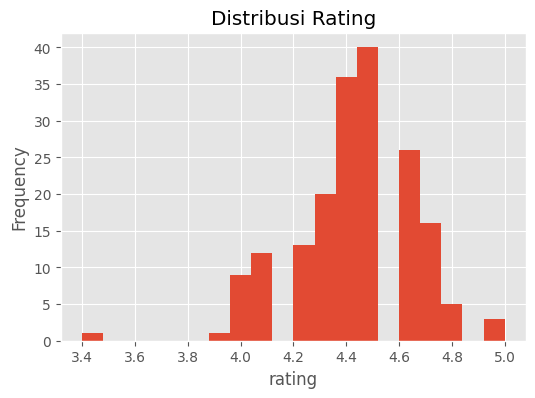

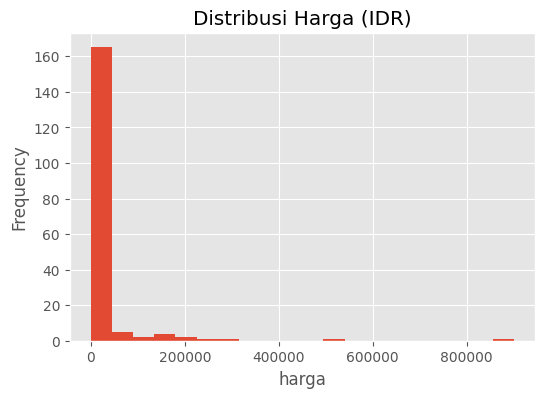

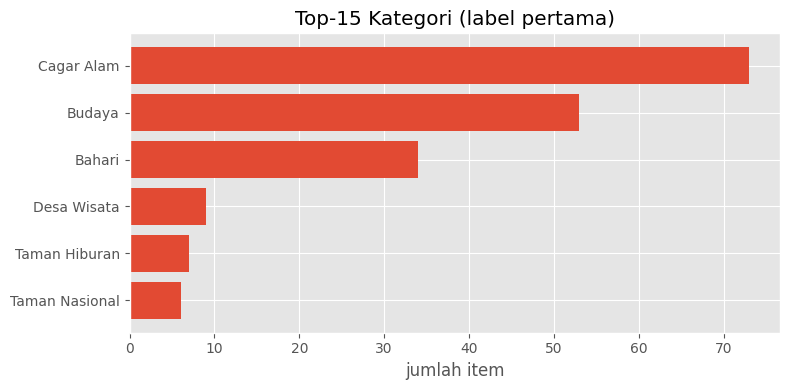

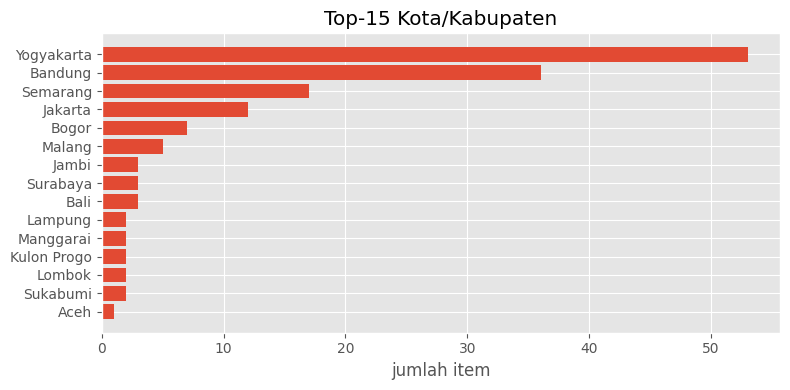

In [15]:
print("Jumlah item:", len(df))
print("\nMissing values:")
print(df[["place_name","place_description","category","city","rating","price"]].isna().sum())

df["desc_len"] = df["place_description"].astype(str).str.len()
df["g_len"]    = df["gabungan"].astype(str).str.len()

print("\nStat panjang deskripsi:")
print(df["desc_len"].describe().to_frame("desc_len"))
print("\nStat panjang gabungan:")
print(df["g_len"].describe().to_frame("gabungan_len"))

fig, ax = plt.subplots(figsize=(6,4))
pd.to_numeric(df["rating"], errors="coerce").plot(kind="hist", bins=20, ax=ax, title="Distribusi Rating")
ax.set_xlabel("rating"); plt.show()

fig, ax = plt.subplots(figsize=(6,4))
pd.to_numeric(df["price"], errors="coerce").plot(kind="hist", bins=20, ax=ax, title="Distribusi Harga (IDR)")
ax.set_xlabel("harga"); plt.show()

cat1 = df["category"].fillna("").apply(lambda s: str(s).split(",")[0].strip())
top_cat = cat1.value_counts().head(15)
fig, ax = plt.subplots(figsize=(8,4))
ax.barh(top_cat.index[::-1], top_cat.values[::-1])
ax.set_title("Top-15 Kategori (label pertama)"); ax.set_xlabel("jumlah item"); plt.tight_layout(); plt.show()

top_city = df["city"].fillna("").str.strip().value_counts().head(15)
fig, ax = plt.subplots(figsize=(8,4))
ax.barh(top_city.index[::-1], top_city.values[::-1])
ax.set_title("Top-15 Kota/Kabupaten"); ax.set_xlabel("jumlah item"); plt.tight_layout(); plt.show()

## 4) Query sintetis & split aman per‑item
Dua bentuk query per item:
- **q_struct_1:** "kategori_kunci kota nama"
- **q_struct_2:** "wisata {kategori} di {kota}"


In [16]:
def q_struct_1(r: pd.Series) -> str:
    cat  = str(r.get("category","" )).split(",")[0].strip()
    city = str(r.get("city",""     )).strip()
    name = str(r.get("place_name","" )).strip()
    toks = [t for t in [cat, city, name] if t]
    return " ".join(toks)

def q_struct_2(r: pd.Series) -> str:
    cat  = str(r.get("category","" )).split(",")[0].strip().lower()
    city = str(r.get("city",""     )).strip().lower()
    base = "wisata"
    if cat:  base += f" {cat}"
    if city: base += f" di {city}"
    return base.strip()

pairs = []
for i, r in df.iterrows():
    for q in (q_struct_1(r), q_struct_2(r)):
        if q and len(q) >= 3:
            pairs.append((q, int(i)))

random.shuffle(pairs)
print("Total pairs:", len(pairs))

MAX_Q = 500
pairs = pairs[:MAX_Q] if MAX_Q else pairs

def preprocess_query(q: str) -> str:
    return normalize_text(q)

q_texts = np.array([preprocess_query(q) for q,_ in pairs], dtype=object)
y_idx   = np.array([idx for _,idx in pairs], dtype=np.int64)

gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, tmp_idx = next(gss1.split(q_texts, y_idx, groups=y_idx))

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_rel_idx, test_rel_idx = next(gss2.split(q_texts[tmp_idx], y_idx[tmp_idx], groups=y_idx[tmp_idx]))
val_idx  = tmp_idx[val_rel_idx]
test_idx = tmp_idx[test_rel_idx]

Q_train, y_train = q_texts[train_idx].tolist(), y_idx[train_idx]
Q_val,   y_val   = q_texts[val_idx].tolist(),   y_idx[val_idx]
Q_test,  y_test  = q_texts[test_idx].tolist(),  y_idx[test_idx]

print("Split sizes -> Train:", len(Q_train), "Val:", len(Q_val), "Test:", len(Q_test))

Total pairs: 364
Split sizes -> Train: 254 Val: 54 Test: 56


## 5) Fitur/Indeks per Metode
- **TF‑IDF (word)**
- **Jaccard token set** (non‑TF‑IDF)
- **SBERT embeddings** (non‑TF‑IDF)


In [17]:
art = {}

# ---- 1) TF-IDF (word) ----
docs_weighted = df["gabungan_weighted"].fillna("").astype(str).str.strip()
if (docs_weighted.str.len() == 0).all():
    warnings.warn("gabungan_weighted kosong; fallback ke kolom 'gabungan'.")
    docs_weighted = df["gabungan"].fillna("").astype(str).str.strip()

def _fit_tfidf(corpus, ngram=(1,3), max_df=1.0):
    vec = TfidfVectorizer(
        max_features=20000,
        ngram_range=ngram,
        min_df=1,
        max_df=max_df,
        sublinear_tf=True,
        norm="l2",
    )
    try:
        X = vec.fit_transform(corpus)
    except ValueError as e:
        if "After pruning, no terms remain" in str(e):
            vec = TfidfVectorizer(
                max_features=20000,
                ngram_range=(1,2),
                min_df=1,
                max_df=1.0,
                sublinear_tf=True,
                norm="l2",
            )
            X = vec.fit_transform(corpus)
        else:
            raise
    return vec, X

vec_word, X_tfidf_word = _fit_tfidf(docs_weighted, ngram=(1,3), max_df=1.0)
save_npz(ART_DIR / "tfidf_word.npz", X_tfidf_word.tocsr())
joblib.dump(vec_word, ART_DIR / "vectorizer_word.joblib")
art["tfidf_word"] = (vec_word, X_tfidf_word)

# ---- 2) Jaccard token sets ----
def _tokens(text: str):
    return set(re.findall(r"\w+", str(text)))

item_tokens = [ _tokens(t) for t in df["gabungan"].astype(str).tolist() ]
joblib.dump(item_tokens, ART_DIR / "item_tokens_jaccard.joblib")
art["jaccard_tokens"] = item_tokens

# ---- 3) SBERT embeddings ----
if SBERT_OK:
    sbert = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    I_emb = sbert.encode(
        df["gabungan"].astype(str).tolist(),
        batch_size=256,
        show_progress_bar=False,
        normalize_embeddings=True
    ).astype("float32")
    np.save(ART_DIR / "sbert_item_emb.npy", I_emb)
    art["sbert"] = (sbert, I_emb)
else:
    art["sbert"] = None

print("Artifacts ready.", "SBERT_OK:", SBERT_OK, "| TFIDF shape:", X_tfidf_word.shape, "| Jaccard items:", len(item_tokens))

Artifacts ready. SBERT_OK: True | TFIDF shape: (182, 2231) | Jaccard items: 182


## 6) Rankers + Query Expansion

In [18]:
# Sinonim sederhana untuk TF-IDF
SYN = {
    "pantai": ["beach"],
    "snorkeling": ["snorkel"],
    "selam": ["diving","dive"],
    "gunung": ["mountain"],
    "taman nasional": ["national park"],
    "air terjun": ["waterfall", "falls"],
    "goa": ["cave"],
    "desa wisata": ["village","tourist village"],
    "kuliner": ["food","culinary","street food"],
    "bahari": ["marine","sea"],
    "danau": ["lake"],
    "bukit": ["hill"],
    "hutan": ["forest","jungle"],
}

def expand_query_for_tfidf(q: str) -> str:
    qn = q.lower()
    extra = []
    for k, vs in SYN.items():
        if k in qn:
            extra.extend(vs)
    if extra:
        qn = qn + " " + " ".join(extra)
    return normalize_text(qn)

def scores_tfidf_word(q: str) -> np.ndarray:
    vec, X = art["tfidf_word"]
    q_expanded = expand_query_for_tfidf(q)
    qv = vec.transform([q_expanded])
    s  = cosine_similarity(X, qv)[:,0]
    return s

def scores_jaccard(q: str) -> np.ndarray:
    T = art["jaccard_tokens"]
    qset = set(re.findall(r"\w+", q))
    scores = np.zeros(len(T), dtype="float32")
    if len(qset) == 0:
        return scores
    for i, tset in enumerate(T):
        if not tset:
            continue
        inter = len(qset & tset)
        union = len(qset | tset)
        scores[i] = inter / union if union > 0 else 0.0
    return scores

def scores_sbert(q: str) -> np.ndarray:
    if art["sbert"] is None:
        return np.zeros(len(df), dtype="float32")
    sbert, I = art["sbert"]
    qv = sbert.encode([q], normalize_embeddings=True)
    s  = (I @ qv.T).ravel()
    return s

METHODS: Dict[str, callable] = {
    "TFIDF(word)": scores_tfidf_word,
    "Jaccard tokens":      scores_jaccard,
    "SBERT cosine":        scores_sbert if art["sbert"] is not None else None,
}
print("Metode aktif:", [m for m,f in METHODS.items() if f is not None])

Metode aktif: ['TFIDF(word)', 'Jaccard tokens', 'SBERT cosine']


## 7) Evaluasi (Recall@10, F1@10, Latency) + Visual

,Method,Recall@10,F1@10,Latency(ms/q)
0,Jaccard tokens,0.907407,0.164983,0.100689
1,TFIDF(word),0.870370,0.158249,0.818130
2,SBERT cosine,0.814815,0.148148,9.765036


,Method,Recall@10,F1@10,Latency(ms/q)
0,TFIDF(word),0.857143,0.155844,0.767960
1,Jaccard tokens,0.803571,0.146104,0.097585
2,SBERT cosine,0.750000,0.136364,10.674900


/tmp/ipython-input-655085210.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")


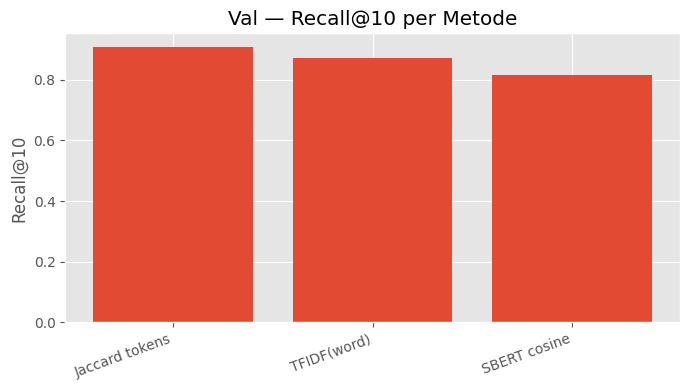

/tmp/ipython-input-655085210.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")


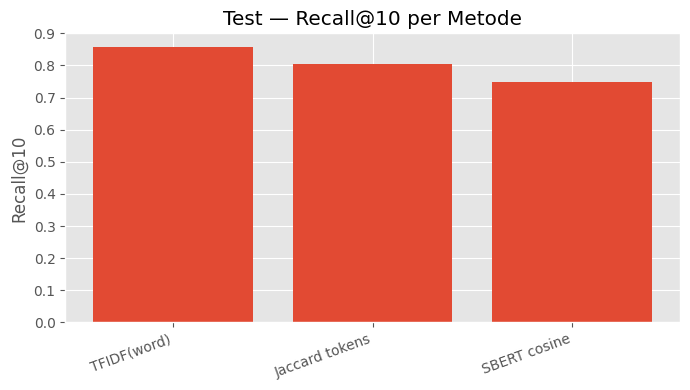

/tmp/ipython-input-655085210.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")


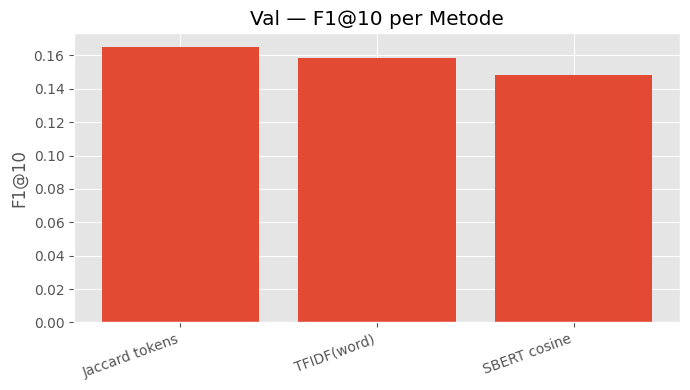

/tmp/ipython-input-655085210.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")


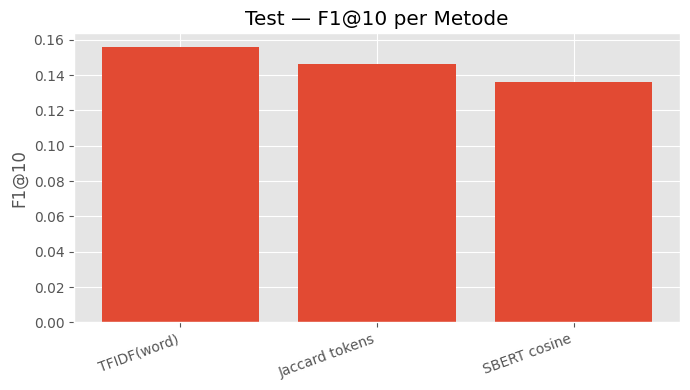

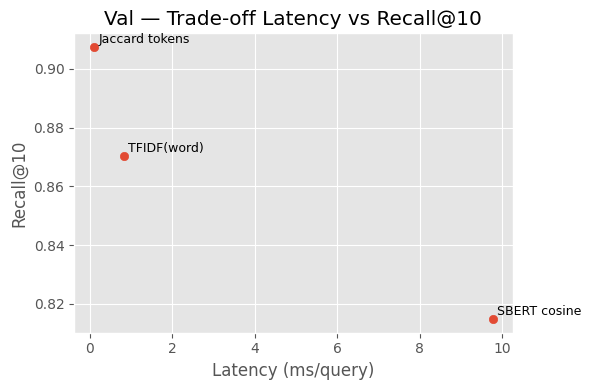

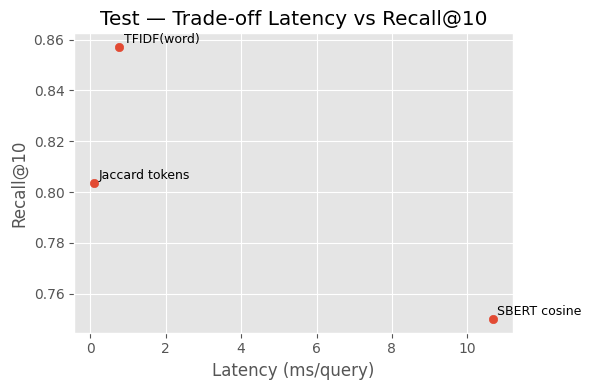

In [19]:
def precision_at_k(rank: List[int], gt: int, k: int=10) -> float:
    return 1.0/float(k) if gt in rank[:k] else 0.0

def recall_at_k(rank: List[int], gt: int, k: int=10) -> float:
    return 1.0 if gt in rank[:k] else 0.0

def f1_at_k(rank: List[int], gt: int, k: int=10) -> float:
    p = precision_at_k(rank, gt, k)
    r = recall_at_k(rank, gt, k)
    return 2*p*r/(p+r) if (p+r) > 0 else 0.0

def evaluate_methods(Q_list: List[str], y_true: np.ndarray, methods=METHODS, k: int=10):
    rows = []
    for name, fn in methods.items():
        if fn is None:
            continue
        t0 = time.perf_counter()
        rec = f1 = 0.0
        for q, gt in zip(Q_list, y_true):
            s = fn(q)
            rank = np.argsort(-s).tolist()
            rec += recall_at_k(rank, int(gt), k)
            f1  += f1_at_k(rank, int(gt), k)
        ms_per_q = (time.perf_counter() - t0) * 1000.0 / max(1, len(Q_list))
        n = float(len(Q_list))
        rows.append({
            "Method": name,
            "Recall@10": rec/n,
            "F1@10": f1/n,
            "Latency(ms/q)": ms_per_q
        })
    res = pd.DataFrame(rows).sort_values("Recall@10", ascending=False).reset_index(drop=True)
    return res

res_val  = evaluate_methods(Q_val,  y_val, METHODS, k=10)
res_test = evaluate_methods(Q_test, y_test, METHODS, k=10)

from IPython.display import display
display(res_val); display(res_test)

def plot_metric_bars(df, metric:str, title:str):
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(df["Method"], df[metric])
    ax.set_title(title); ax.set_ylabel(metric); ax.set_xticklabels(df["Method"], rotation=20, ha="right")
    plt.tight_layout(); plt.show()

for m in ["Recall@10","F1@10"]:
    plot_metric_bars(res_val,  m, f"Val — {m} per Metode")
    plot_metric_bars(res_test, m, f"Test — {m} per Metode")

def plot_latency_tradeoff(df, split_name):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(df["Latency(ms/q)"], df["Recall@10"])
    for _,row in df.iterrows():
        ax.annotate(row["Method"], (row["Latency(ms/q)"], row["Recall@10"]), fontsize=9, xytext=(3,3), textcoords="offset points")
    ax.set_title(f"{split_name} — Trade‑off Latency vs Recall@10")
    ax.set_xlabel("Latency (ms/query)"); ax.set_ylabel("Recall@10")
    plt.tight_layout(); plt.show()

plot_latency_tradeoff(res_val,  "Val")
plot_latency_tradeoff(res_test, "Test")

## 8) Simpan metrics & demo Top‑K

In [20]:
res_val.assign(Split="Val").to_csv(ART_DIR / "metrics_val.csv", index=False)
res_test.assign(Split="Test").to_csv(ART_DIR / "metrics_test.csv", index=False)
print("Saved:", (ART_DIR / "metrics_val.csv").as_posix(), "|", (ART_DIR / "metrics_test.csv").as_posix())

meta = {
    "created_at": dt.datetime.utcnow().isoformat() + "Z",
    "seed": 42,
    "methods": [m for m,f in (METHODS.items()) if f is not None],
    "tfidf_boosted": {"ngram_range": [1,3], "min_df": 1, "max_df": 1.0,
                      "field_boost": {"name":3,"category":2,"city":2,"desc":1}},
}
with open(ART_DIR / "meta.json","w") as f:
    json.dump(meta, f, indent=2)
print("Metadata saved to:", (ART_DIR / "meta.json").as_posix())

def retrieve_demo(q: str, k: int = 5, method: str = "TFIDF(word) boosted"):
    fn = METHODS[method]
    s  = fn(q)
    order = np.argsort(-s)[:k]
    return list(zip(order.tolist(), s[order].tolist()))

print("Demo:", retrieve_demo("pantai snorkeling aceh", k=5, method=list(METHODS.keys())[0]))

Saved: artifacts_cbf_bench_3_no_bm25/metrics_val.csv | artifacts_cbf_bench_3_no_bm25/metrics_test.csv
Metadata saved to: artifacts_cbf_bench_3_no_bm25/meta.json
Demo: [(0, 0.2084211311288797), (161, 0.10830182915863933), (162, 0.10830182915863933), (163, 0.10830182915863933), (164, 0.10830182915863933)]


/tmp/ipython-input-1370961518.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": dt.datetime.utcnow().isoformat() + "Z",
